In [1]:
! pip install torch
! pip install gymnasium[atari,accept-rom-license] ale-py==0.8.1

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
import numpy
print(numpy.__version__)

1.22.2


In [6]:
pip install "numpy<2.0"

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import numpy as np


import cv2
import gymnasium as gym

from gymnasium import spaces # <-- この行を追加

import matplotlib.pyplot as plt
from matplotlib import animation

import torch
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

from IPython.display import HTML

%load_ext tensorboard

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
!nvidia-smi

Mon Sep 29 17:52:29 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   54C    P8              17W /  72W |      3MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
"""
    初期状態を多様化するため， ランダムに選んだ回数最初に「何もしない」行動をする．
"""
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        # 1. resetからobsとinfoの両方を受け取る
        obs, info = self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(1, self.noop_max + 1)
        assert noops > 0

        for _ in range(noops):
            # 2. stepから5つの値を受け取る
            obs, reward, terminated, truncated, info = self.env.step(self.noop_action)
            # 3. 終了判定を gymnasium 形式に変更
            if terminated or truncated:
                obs, info = self.env.reset(**kwargs)
        # 4. 最後にobsとinfoの両方を返す
        return obs, info

    def step(self, ac):
        # 5. stepもgymnasiumの返り値の数に合わせる
        return self.env.step(ac)


"""
    問題を解きやすくするため, 選んだ同じ行動を何度か繰り返す.
    同時に, Atariではフレームの偶奇で描画が異なる場合があるため, 直近２フレームでMaxを取る.
"""
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        gym.Wrapper.__init__(self, env)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, *args = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, *args

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


"""
    環境をわかりやすくする, および更なる初期状態の多様化のため, 残機が複数あるゲームでも
    １機失うたびに終了とする (done=True). ただし, 状態はリセットしない
"""
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        # 1. stepから5つの値を受け取る
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # 2. 終了判定を更新
        self.was_real_done = terminated or truncated
        
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # 残機が減ったら、エピソード終了（terminated）と見なす
            terminated = True
            
        self.lives = lives
        
        # 3. 最後に5つの値を返す
        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        # was_real_doneがTrueでもFalseでも、最終的に(obs, info)を返すようにする
        if self.was_real_done:
            obs, info = self.env.reset(**kwargs)
        else:
        # stepからは5つの値が返ってくる。infoも受け取る
            obs, reward, terminated, truncated, info = self.env.step(0)
        # もしこのstepで終了してしまったら、再度resetをかける
            if terminated or truncated:
                obs, info = self.env.reset(**kwargs)
            
        self.lives = self.env.unwrapped.ale.lives()
    
        # 常にobsとinfoの2つを返す
        return obs, info


"""
    いくつかの環境では, 最初にエージェントが”FIRE"（球の発射など）しないとゲームが開始しないため,
    自動で”FIRE"して強制的にゲームを開始する.
"""
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        # 1. resetからobsとinfoを受け取る
        obs, info = self.env.reset(**kwargs)
        
        # 2. stepから5つの値を受け取る
        obs, reward, terminated, truncated, info = self.env.step(1)
        # 3. 終了判定をgymnasium形式に
        if terminated or truncated:
            obs, info = self.env.reset(**kwargs)
            
        # 2回目も同様に修正
        obs, reward, terminated, truncated, info = self.env.step(2)
        if terminated or truncated:
            obs, info = self.env.reset(**kwargs)
            
        # 4. 最後にobsとinfoを返す
        return obs, info

    def step(self, ac):
        return self.env.step(ac)


"""
    そのままの画像ではサイズが大きすぎるため, サイズを84x84に縮小した上でグレイスケール化する.
"""
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs

"""
    同じハイパーパラメータを環境に関わらず使い回せるように, 報酬を {-1, 0, 1} にクリップする.
"""
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        return np.sign(reward)


"""
    以下のFrameStackをメモリ効率よく行うためのクラス
"""
class LazyFrames(object):
    def __init__(self, frames):
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]


"""
    環境がマルコフ決定過程に近づくように, 画像をスタックして状態とする
    ※ 学習時間の短縮のため, 今回は適用しません
"""
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    # 1. resetの定義を gymnasium 形式に変更
    def reset(self, *, seed=None, options=None):
        # 2. resetから obs と info を受け取り、引数も渡す
        ob, info = self.env.reset(seed=seed, options=options)
        for _ in range(self.k):
            self.frames.append(ob)
        # 3. 最後に obs と info の両方を返す
        return self._get_ob(), info

    # 4. stepの定義も gymnasium 形式に修正
    def step(self, action):
        # 5. stepから5つの値を受け取る
        ob, reward, terminated, truncated, info = self.env.step(action)
        self.frames.append(ob)
        # 6. 5つの値を返す
        return self._get_ob(), reward, terminated, truncated, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

In [6]:
"""
    PyTorchで扱いやすいように観測をChannel-Firstに変更しつつ, Torch.Tensorに変換する.
"""
class TorchFrame(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        height, width, channels = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(channels, height, width),
            dtype=np.uint8,
        )

    def observation(self, obs):
        # 1. np.array()でLazyFramesをNumPy配列に変換する
        np_obs = np.array(obs)
        # 2. NumPy配列に変換してからtransposeを実行
        return torch.as_tensor(np_obs.transpose([2, 0, 1]))

In [7]:
from collections import deque

def make_env(noop_max=30, skip=4, width=84, height=84, grayscale=True):
    # バージョンの関係で，自動で追加されるOrderEnforcingWrapperが悪さをしてました．
    env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')
    env = NoopResetEnv(env, noop_max=noop_max)
    env = MaxAndSkipEnv(env, skip=skip)
    env = EpisodicLifeEnv(env)
    env = FireResetEnv(env)
    env = WarpFrame(env, width=width, height=height, grayscale=grayscale)
    
    # ↓↓↓【重要】WarpFrameの後、TorchFrameの前にFrameStackを追加 ↓↓↓
    env = FrameStack(env, 4)
    
    env = ClipRewardEnv(env)
    env = TorchFrame(env)
    return env

env = make_env()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [8]:
# プレイの様子を動画で見てみるための関数
def display_video(frames):
    plt.figure(figsize=(8, 8), dpi=50)
    patch = plt.imshow(frames[0], cmap='gray')
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml(default_mode='once')))
    plt.close()

In [9]:
env

<TorchFrame<ClipRewardEnv<FrameStack<WarpFrame<FireResetEnv<EpisodicLifeEnv<MaxAndSkipEnv<NoopResetEnv<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/Breakout-v5>>>>>>>>>>>>

'./logs' からログを読み込んでいます...
  - 読み込み中: events.out.tfevents.1759124308.99fb08e42e1c.2808.0
  - 読み込み中: events.out.tfevents.1759128888.99fb08e42e1c.2808.1
  - 読み込み中: events.out.tfevents.1759129772.99fb08e42e1c.126.0
  - 読み込み中: events.out.tfevents.1759134581.99fb08e42e1c.126.1
  - 読み込み中: events.out.tfevents.1759137115.99fb08e42e1c.748.0
  - 読み込み中: events.out.tfevents.1759142028.99fb08e42e1c.748.1
  - 読み込み中: events.out.tfevents.1759142470.99fb08e42e1c.985.0
  - 読み込み中: events.out.tfevents.1759147480.99fb08e42e1c.985.1
  - 読み込み中: events.out.tfevents.1759147709.99fb08e42e1c.1208.0
  - 読み込み中: events.out.tfevents.1759148923.99fb08e42e1c.126.0
  - 読み込み中: events.out.tfevents.1759153781.99fb08e42e1c.126.1
データの読み込みが完了しました。
グラフを作成しています...


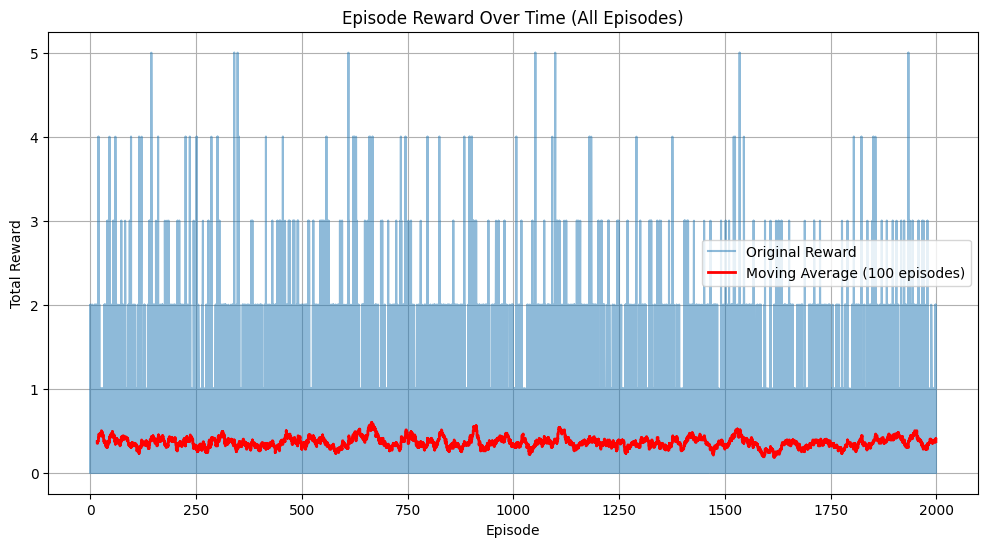

グラフが 'final_reward_graph.png' として保存されました。


In [10]:
#最終版グラフ


import matplotlib.pyplot as plt
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator
import os

# --- 1. 全てのログファイルからデータを抽出 ---
log_dir = './logs'
all_rewards = []

print(f"'{log_dir}' からログを読み込んでいます...")
# logsフォルダ内の全てのイベントファイルに対してループ
log_files = [f for f in os.listdir(log_dir) if f.startswith('events.out.tfevents')]

for log_file in log_files:
    file_path = os.path.join(log_dir, log_file)
    print(f"  - 読み込み中: {log_file}")
    
    # 各ログファイルを読み込む
    ea = event_accumulator.EventAccumulator(file_path, size_guidance={event_accumulator.SCALARS: 0})
    ea.Reload()
    
    # 'Reward' タグのデータが存在すればリストに追加
    if 'Reward' in ea.Tags()['scalars']:
        rewards = ea.scalars.Items('Reward')
        all_rewards.extend(rewards)

print("データの読み込みが完了しました。")

# --- 2. データを時系列順にソート ---
# 複数のファイルから読み込んだため、ステップ（エピソード）順に並べ替える
all_rewards.sort(key=lambda x: x.step)

# ステップと値のリストをそれぞれ作成
steps = [r.step for r in all_rewards]
values = [r.value for r in all_rewards]

# --- 3. グラフの描画と移動平均の計算 ---
print("グラフを作成しています...")
plt.figure(figsize=(12, 6))

# 元の報酬データをプロット
plt.plot(steps, values, alpha=0.5, label='Original Reward')

# Pandasを使って移動平均を計算 (window=100は100エピソードごとの平均)
s_values = pd.Series(values)
moving_avg = s_values.rolling(window=100).mean()

# 移動平均をプロット
plt.plot(steps, moving_avg, color='red', linewidth=2, label='Moving Average (100 episodes)')

# --- 4. グラフの装飾と保存 ---
plt.title('Episode Reward Over Time (All Episodes)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.legend()
plt.savefig('final_reward_graph.png') # ファイルとして保存
plt.show()

print("グラフが 'final_reward_graph.png' として保存されました。")

In [10]:
obs, info = env.reset()
frames = []
total_reward = 0
terminated = False
truncated = False


# Loop until the episode is terminated OR truncated
while not (terminated or truncated):
    frames.append(obs[0])
    action = env.action_space.sample()
    # Unpack all 5 values correctly
    next_obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    obs = next_obs

print('Reward: ', total_reward)
display_video(frames)

Reward:  1.0


In [13]:
# First, update the package list, and then install ffmpeg
!apt-get update && apt-get -y install ffmpeg > /dev/null

Hit:1 https://packages.cloud.google.com/apt cloud-sdk InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Fetched 384 kB in 1s (361 kB/s)  
Reading package lists... Done


In [41]:
print(f"合計フレーム数: {len(frames)}")

合計フレーム数: 5


In [31]:
# 必要なライブラリをインポート
from matplotlib import animation
import matplotlib.pyplot as plt

# このコードは、前のセルで作成された 'frames' という名前のリストが存在することを前提としています

# 1. アニメーションの土台となる図を準備
fig = plt.figure()
plt.axis('off') # 枠線や軸を非表示に
im = plt.imshow(frames[0], cmap='gray')

# 2. 1フレームずつ画像を描画し直すための関数
def update_frame(i):
    im.set_data(frames[i])
    return [im]

# 3. アニメーションオブジェクトを作成
# fps=30 は「1秒間に30フレーム」という意味です
anim = animation.FuncAnimation(fig, update_frame, frames=len(frames), interval=1000/30)

# 4. mp4ファイルとして保存
# ファイル名は何でもOKです
file_path = "random_agent_play.mp4" 
anim.save(file_path, writer="ffmpeg")

plt.close(fig) # Jupyter Notebook内に余計なプロットが表示されるのを防ぐ

print(f"動画を {file_path} として保存しました。")

動画を random_agent_play.mp4 として保存しました。


In [11]:
import gymnasium as gym

# 1. ラッパーを一切使わずに環境を作成
env_base = gym.make('ALE/Breakout-v5')

# 2. これが正常に動作することを確認
obs, info = env_base.reset()

print("ベース環境のresetは成功しました！")
print("obsの形状:", obs.shape)

ベース環境のresetは成功しました！
obsの形状: (210, 160, 3)


In [12]:
# ステップ1の続き...

# 3. ラッパーを一つずつ追加してテストしていく
try:
    print("\n--- ラッパーのテストを開始 ---")
    
    # NoopResetEnvを追加
    env_wrapped = NoopResetEnv(env_base, noop_max=30)
    obs, info = env_wrapped.reset()
    print("✅ NoopResetEnv はOK")

    # EpisodicLifeEnvを追加
    env_wrapped = EpisodicLifeEnv(env_wrapped)
    obs, info = env_wrapped.reset()
    print("✅ EpisodicLifeEnv はOK")

    # FireResetEnvを追加
    env_wrapped = FireResetEnv(env_wrapped)
    obs, info = env_wrapped.reset()
    print("✅ FireResetEnv はOK")

    # WarpFrameを追加
    env_wrapped = WarpFrame(env_wrapped)
    obs, info = env_wrapped.reset()
    print("✅ WarpFrame はOK")

    # ClipRewardEnvを追加
    env_wrapped = ClipRewardEnv(env_wrapped)
    obs, info = env_wrapped.reset()
    print("✅ ClipRewardEnv はOK")
    
    # TorchFrameを追加
    env_wrapped = TorchFrame(env_wrapped)
    obs, info = env_wrapped.reset()
    print("✅ TorchFrame はOK")

except ValueError as e:
    print("\n❌ エラーが発生しました！")
    print("直前に追加したラッパーが原因の可能性が高いです。")
    print(e)


--- ラッパーのテストを開始 ---
✅ NoopResetEnv はOK
✅ EpisodicLifeEnv はOK
✅ FireResetEnv はOK
✅ WarpFrame はOK
✅ ClipRewardEnv はOK
✅ TorchFrame はOK


In [11]:
"""
   Prioritized Experience Replayを実現するためのメモリクラス.
"""
class PrioritizedReplayBuffer(object):
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.index = 0
        self.buffer = []
        self.priorities = np.zeros(buffer_size, dtype=np.float32)
        self.priorities[0] = 1.0

    def __len__(self):
        return len(self.buffer)

    # 経験をリプレイバッファに保存する． 経験は(obs, action, reward, next_obs, done)の5つ組を想定
    def push(self, experience):
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(experience)
        else:
            self.buffer[self.index] = experience

        # 優先度は最初は大きな値で初期化しておき, 後でサンプルされた時に更新する
        self.priorities[self.index] = self.priorities.max()
        self.index = (self.index + 1) % self.buffer_size

    def sample(self, batch_size, alpha=0.6, beta=0.4):
        # 現在経験が入っている部分に対応する優先度を取り出し, サンプルする確率を計算
        priorities = self.priorities[: self.buffer_size if len(self.buffer) == self.buffer_size else self.index]
        priorities = priorities ** alpha
        prob = priorities / priorities.sum()

        # >> 演習: 確率probに従ってサンプルする経験のインデックスを用意しましょう
        # ヒント: np.random.choice などが便利です
        indices = np.random.choice(len(self.buffer), batch_size, p=prob)

        # >> 演習: 上式の通りに重点サンプリングの補正のための重みを計算してみましょう

        weights = (len(self.buffer) * prob[indices]) ** (-beta)
        weights = weights / weights.max()


        # 上でサンプルしたインデックスに基づいて経験をサンプルし, (obs, action, reward, next_obs, done)に分ける
        obs, action, reward, next_obs, done = zip(*[self.buffer[i] for i in indices])

        # あとで計算しやすいようにtorch.Tensorに変換して(obs, action, reward, next_obs, done, indices, weights)の7つ組を返す
        return (torch.stack(obs),
                torch.as_tensor(action),
                torch.as_tensor(reward, dtype=torch.float32),
                torch.stack(next_obs),
                torch.as_tensor(done, dtype=torch.uint8),
                indices,
                torch.as_tensor(weights, dtype=torch.float32))

    # 優先度を更新する. 優先度が極端に小さくなって経験が全く選ばれないということがないように, 微小値を加算しておく.
    def update_priorities(self, indices, priorities):
        self.priorities[indices] = priorities + 1e-4

In [12]:
"""
    Dueling Networkを用いたQ関数を実現するためのニューラルネットワークをクラスとして記述します.
"""
class CNNQNetwork(nn.Module):
    def __init__(self, state_shape, n_action):
        super(CNNQNetwork, self).__init__()
        self.state_shape = state_shape
        self.n_action = n_action
        # Dueling Networkでも, 畳込み部分は共有する
        self.conv_layers = nn.Sequential(
            nn.Conv2d(state_shape[0], 32, kernel_size=8, stride=4),  # 1x84x84 -> 32x20x20
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # 32x20x20 -> 64x9x9
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # 64x9x9 -> 64x7x7
            nn.ReLU()
        )

        # Dueling Networkのための分岐した全結合層
        # 状態価値
        self.fc_state = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        # アドバンテージ
        self.fc_advantage = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, n_action)
        )

    def forward(self, obs):
        feature = self.conv_layers(obs)
        feature = feature.view(feature.size(0), -1)  #　Flatten. 64x7x7　-> 3136

        state_values = self.fc_state(feature)
        advantage = self.fc_advantage(feature)

        # 状態価値 + アドバンテージ で行動価値を計算しますが、安定化のためアドバンテージの（行動間での）平均を引きます
        action_values = state_values + advantage - torch.mean(advantage, dim=1, keepdim=True)
        return action_values

    # epsilon-greedy. 確率epsilonでランダムに行動し, それ以外はニューラルネットワークの予測結果に基づいてgreedyに行動します.
    def act(self, obs, epsilon):
        if random.random() < epsilon:
            action = random.randrange(self.n_action)
        else:
            # 行動を選択する時には勾配を追跡する必要がない
            with torch.no_grad():
                action = torch.argmax(self.forward(obs.unsqueeze(0))).item()
        return action

In [20]:
#最終版動画


import numpy as np
import gymnasium as gym
import torch
from IPython.display import HTML
from base64 import b64encode
from matplotlib import animation
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------------
# !!! 注意 !!!
# 以下は、あなたの「CNNQNetwork」クラスと「device」変数が定義されていることを前提としています。
# もし定義されていない場合は、まずそれらのセルを実行してください。
# -----------------------------------------------------------------------------------

# 最終学習済みモデルを読み込む (重要: 'breakout_checkpoint.pth' が正しいファイル名か確認！)
# モデルのインスタンスを再度作成
state_shape = (4, 84, 84) # あなたの環境のstate_shapeに合わせてください
n_action = 4 # あなたの環境の行動数に合わせてください (Breakoutの場合4)

net = CNNQNetwork(state_shape, n_action=n_action).to(device)

try:
    checkpoint = torch.load('breakout_checkpoint.pth')
    net.load_state_dict(checkpoint['net_state_dict'])
    print("✅ 最終学習済みモデルを読み込みました。")
except FileNotFoundError:
    print("❌ モデルファイル 'breakout_checkpoint.pth' が見つかりません。パスを確認してください。")
    # モデルが見つからない場合はここで処理を中断するか、エラーハンドリングをしてください。
    exit() # ColabやJupyterで実行する場合は、この行はコメントアウトした方が良いかもしれません。

# 評価用環境の準備 (レンダーモードを 'rgb_array_list' に設定)
# これにより、フレームがリストとして取得できるようになります。
eval_env = gym.make("BreakoutNoFrameskip-v4", render_mode='rgb_array')
eval_env = gym.wrappers.AtariPreprocessing(eval_env, noop_max=30, frame_skip=4, screen_size=84, terminal_on_life_loss=False, grayscale_obs=True)
eval_env = gym.wrappers.FrameStack(eval_env, 4)

# -----------------------------------------------------------------------------------
# エージェントに1エピソードプレイさせて、フレームを記録する
# -----------------------------------------------------------------------------------
frames = [] # 1. まず空のリストを準備
obs, info = eval_env.reset()
terminated = False
truncated = False
total_reward = 0

# --- ↓↓↓ この3行を追加！ ↓↓↓ ---
# Action '1' は「FIRE」です。最初の一手だけ手動で実行してゲームを開始します。
obs, reward, terminated, truncated, info = eval_env.step(1)
total_reward += reward
# --- ↑↑↑ ここまで ---

print("エージェントがゲームをプレイしています...")
while not (terminated or truncated):
    # .render()で現在の画面(NumPy配列)を取得し、リストに追加する
    frames.append(eval_env.render())

    action = net.act(torch.tensor(np.array(obs)).float().to(device), epsilon=0.0)
    
    next_obs, reward, terminated, truncated, info = eval_env.step(action)
    total_reward += reward
    obs = next_obs

eval_env.close()
print(f"プレイ終了。総報酬: {total_reward}。合計フレーム数: {len(frames)}")

# -----------------------------------------------------------------------------------
# 記録したフレームから動画を作成し、保存する
# -----------------------------------------------------------------------------------

if len(frames) > 1:
    print("動画ファイルを作成しています...")
    height, width = frames[0].shape[:2]
    dpi = 100
    figsize = width / dpi, height / dpi
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.axis('off')
    im = plt.imshow(frames[0])

    def animate(i):
        im.set_data(frames[i])
        return [im]

    # アニメーションを作成 (fps=30 は1秒間に30フレームの意味)
    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=1000/30)

    # mp4ファイルとして保存
    file_path = "breakout_final_agent_play.mp4" # 最終版の動画であることが分かる名前に変更
    
    # PillowWriterを使う場合はFFmpegWriterをコメントアウト
    # from matplotlib.animation import PillowWriter
    # anim.save(file_path, writer=PillowWriter(fps=30))
    
    # FFmpegWriterが推奨
    # !apt-get update && apt-get install -y ffmpeg # ColabでFFmpegがない場合、この行を実行
    anim.save(file_path, writer="ffmpeg") 

    plt.close(fig) # 表示用のプロットを閉じる
    print(f"動画を {file_path} として保存しました。")
else:
    print("フレームが記録されませんでした。")

✅ 最終学習済みモデルを読み込みました。
エージェントがゲームをプレイしています...


/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


プレイ終了。総報酬: 0.0。合計フレーム数: 26992
動画ファイルを作成しています...
動画を breakout_final_agent_play.mp4 として保存しました。


In [13]:
"""
    リプレイバッファの宣言
"""
buffer_size = 100000  #　リプレイバッファに入る経験の最大数
initial_buffer_size = 10000  # 学習を開始する最低限の経験の数
replay_buffer = PrioritizedReplayBuffer(buffer_size)


"""
    ネットワークの宣言
"""
net = CNNQNetwork(env.observation_space.shape, n_action=env.action_space.n).to(device)
target_net = CNNQNetwork(env.observation_space.shape, n_action=env.action_space.n).to(device)
target_update_interval = 10000  # 学習安定化のために用いるターゲットネットワークの同期間隔


"""
    オプティマイザとロス関数の宣言
"""
optimizer = optim.Adam(net.parameters(), lr=0.0005)  # オプティマイザはAdam
loss_func = nn.SmoothL1Loss(reduction='none')  # ロスはSmoothL1loss（別名Huber loss）



# チェックポイントファイルが存在すれば読み込む (2回目以降の学習)
try:
    checkpoint = torch.load('breakout_checkpoint.pth')
    net.load_state_dict(checkpoint['net_state_dict'])
    target_net.load_state_dict(checkpoint['target_net_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("✅ チェックポイントを読み込みました。学習を再開します。")
except FileNotFoundError:
    print("ℹ️ チェックポイントが見つかりません。最初から学習を開始します。")


"""
    Prioritized Experience Replayのためのパラメータβ
"""
beta_begin = 0.4
beta_end = 1.0
beta_decay = 500000
# beta_beginから始めてbeta_endまでbeta_decayかけて線形に増やす
beta_func = lambda step: min(beta_end, beta_begin + (beta_end - beta_begin) * (step / beta_decay))


"""
    探索のためのパラメータε
"""
epsilon_begin = 1.0
epsilon_end = 0.01
epsilon_decay = 50000
# epsilon_beginから始めてepsilon_endまでepsilon_decayかけて線形に減らす
epsilon_func = lambda step: max(epsilon_end, epsilon_begin - (epsilon_begin - epsilon_end) * (step / epsilon_decay))


"""
    その他のハイパーパラメータ
"""
gamma = 0.99  #　割引率
batch_size = 32
n_episodes = 10000  # 学習を行うエピソード数

✅ チェックポイントを読み込みました。学習を再開します。


In [14]:
def update(batch_size, beta):
    obs, action, reward, next_obs, done, indices, weights = replay_buffer.sample(batch_size, beta)
    obs, action, reward, next_obs, done, weights \
        = obs.float().to(device), action.to(device), reward.to(device), next_obs.float().to(device), done.to(device), weights.to(device)

    #　ニューラルネットワークによるQ関数の出力から, .gatherで実際に選択した行動に対応する価値を集めてきます.
    q_values = net(obs).gather(1, action.unsqueeze(1)).squeeze(1)

    # 目標値の計算なので勾配を追跡しない
    with torch.no_grad():
        # Double DQN.
        # >> 演習: Double DQNのターゲット価値の計算を実装してみましょう
        # ① 現在のQ関数でgreedyに行動を選択し,
        greedy_action_next = greedy_action_next = torch.argmax(net(next_obs), dim=1)
        # ②　対応する価値はターゲットネットワークのものを参照します.
        q_values_next = q_values_next = target_net(next_obs).gather(1, greedy_action_next.unsqueeze(1)).squeeze(1)

    # ベルマン方程式に基づき, 更新先の価値を計算します.
    # (1 - done)をかけているのは, ゲームが終わった後の価値は0とみなすためです.
    target_q_values = reward + gamma * q_values_next * (1 - done)

    # Prioritized Experience Replayのために, ロスに重み付けを行なって更新します.
    optimizer.zero_grad()
    loss = (weights * loss_func(q_values, target_q_values)).mean()
    loss.backward()
    optimizer.step()

    #　TD誤差に基づいて, サンプルされた経験の優先度を更新します.
    replay_buffer.update_priorities(indices, (target_q_values - q_values).abs().detach().cpu().numpy())

    return loss.item()

In [ ]:
# TensorBoardをColab内に起動. リアルタイムに学習経過が更新されます
writer = SummaryWriter('./logs')
%tensorboard --logdir="logs"

In [32]:
#!kill 461

In [16]:
step = 0
for episode in range(n_episodes):
    # 修正点1: obsとinfoを正しく2つの変数で受け取る
    obs, info = env.reset() 
    
    # 修正点2: 新しい終了フラグを準備
    terminated = False
    truncated = False
    total_reward = 0

    # 修正点2: 新しい終了条件でループ
    while not (terminated or truncated):
        action = net.act(obs.float().to(device), epsilon_func(step))
        
        # 修正点3: stepから5つの値を受け取る
        next_obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        done = terminated or truncated
        replay_buffer.push([obs, action, reward, next_obs, done])
        obs = next_obs

        # ネットワークを更新
        if len(replay_buffer) > initial_buffer_size:
            # update関数からlossの値を受け取る
            loss = update(batch_size, beta_func(step))
            # TensorBoardに'Loss'として記録する
            writer.add_scalar('Loss', loss, step)

        # ターゲットネットワークを定期的に同期させる
        if (step + 1) % target_update_interval == 0:
            target_net.load_state_dict(net.state_dict())

        step += 1
        

    print('Episode: {},  Step: {},  Reward: {}'.format(episode + 1, step + 1, total_reward))
    writer.add_scalar('Reward', total_reward, episode)
    # ↓↓↓ このprint文を追加！ ↓↓↓
    print(f"【ログ記録確認】Episode {episode}: Reward {total_reward} を記録しました。")
    
    # ↓↓↓ この一行を追加するだけ！ ↓↓↓
    writer.flush()
    
    
# --- ↓↓↓ ループが完全に終わった、この場所です！ ↓↓↓ ---
# 2000エピソードの学習成果をまとめて保存する
torch.save({
    'net_state_dict': net.state_dict(),
    'target_net_state_dict': target_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'breakout_checkpoint.pth')

print("✅ 現在の学習状態を 'breakout_checkpoint.pth' として保存しました。")


writer.close()

Episode: 1,  Step: 18,  Reward: 1.0
【ログ記録確認】Episode 0: Reward 1.0 を記録しました。
Episode: 2,  Step: 21,  Reward: 0.0
【ログ記録確認】Episode 1: Reward 0.0 を記録しました。
Episode: 3,  Step: 26,  Reward: 0.0
【ログ記録確認】Episode 2: Reward 0.0 を記録しました。
Episode: 4,  Step: 42,  Reward: 1.0
【ログ記録確認】Episode 3: Reward 1.0 を記録しました。
Episode: 5,  Step: 47,  Reward: 0.0
【ログ記録確認】Episode 4: Reward 0.0 を記録しました。
Episode: 6,  Step: 59,  Reward: 1.0
【ログ記録確認】Episode 5: Reward 1.0 を記録しました。
Episode: 7,  Step: 71,  Reward: 1.0
【ログ記録確認】Episode 6: Reward 1.0 を記録しました。
Episode: 8,  Step: 76,  Reward: 0.0
【ログ記録確認】Episode 7: Reward 0.0 を記録しました。
Episode: 9,  Step: 92,  Reward: 1.0
【ログ記録確認】Episode 8: Reward 1.0 を記録しました。
Episode: 10,  Step: 97,  Reward: 0.0
【ログ記録確認】Episode 9: Reward 0.0 を記録しました。
Episode: 11,  Step: 113,  Reward: 1.0
【ログ記録確認】Episode 10: Reward 1.0 を記録しました。
Episode: 12,  Step: 116,  Reward: 0.0
【ログ記録確認】Episode 11: Reward 0.0 を記録しました。
Episode: 13,  Step: 121,  Reward: 0.0
【ログ記録確認】Episode 12: Reward 0.0 を記録しました。
Episode: 14,  S

KeyboardInterrupt: 

In [17]:
# 現在のモデルの重みをファイルに保存します
torch.save({
    'net_state_dict': net.state_dict(),
    'target_net_state_dict': target_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'breakout_checkpoint_final.pth') # 新しい名前で保存

print("✅ 中断時点のモデルを'breakout_checkpoint_final.pth'として保存しました。")

✅ 中断時点のモデルを'breakout_checkpoint_final.pth'として保存しました。


'./logs' からログを読み込んでいます...
  - 読み込み中: events.out.tfevents.1759168449.99fb08e42e1c.1436.0
データの読み込みが完了しました。
グラフを作成しています...


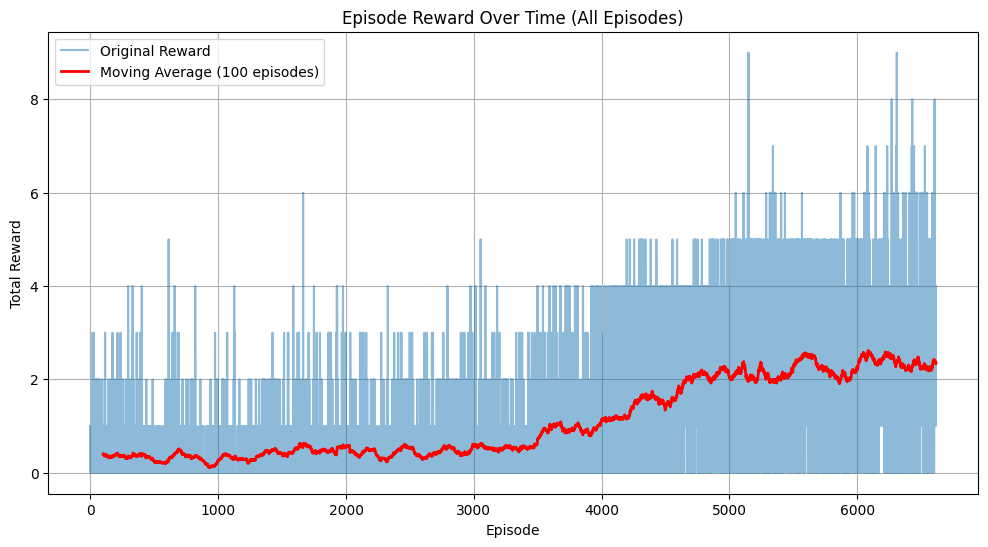

グラフが 'final_reward_graph.png' として保存されました。


In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator
import os

# --- 1. 全てのログファイルからデータを抽出 ---
log_dir = './logs'
all_rewards = []

print(f"'{log_dir}' からログを読み込んでいます...")
# logsフォルダ内の全てのイベントファイルに対してループ
log_files = [f for f in os.listdir(log_dir) if f.startswith('events.out.tfevents')]

for log_file in log_files:
    file_path = os.path.join(log_dir, log_file)
    print(f"  - 読み込み中: {log_file}")
    
    # 各ログファイルを読み込む
    ea = event_accumulator.EventAccumulator(file_path, size_guidance={event_accumulator.SCALARS: 0})
    ea.Reload()
    
    # 'Reward' タグのデータが存在すればリストに追加
    if 'Reward' in ea.Tags()['scalars']:
        rewards = ea.scalars.Items('Reward')
        all_rewards.extend(rewards)

print("データの読み込みが完了しました。")

# --- 2. データを時系列順にソート ---
# 複数のファイルから読み込んだため、ステップ（エピソード）順に並べ替える
all_rewards.sort(key=lambda x: x.step)

# ステップと値のリストをそれぞれ作成
steps = [r.step for r in all_rewards]
values = [r.value for r in all_rewards]

# --- 3. グラフの描画と移動平均の計算 ---
print("グラフを作成しています...")
plt.figure(figsize=(12, 6))

# 元の報酬データをプロット
plt.plot(steps, values, alpha=0.5, label='Original Reward')

# Pandasを使って移動平均を計算 (window=100は100エピソードごとの平均)
s_values = pd.Series(values)
moving_avg = s_values.rolling(window=100).mean()

# 移動平均をプロット
plt.plot(steps, moving_avg, color='red', linewidth=2, label='Moving Average (100 episodes)')

# --- 4. グラフの装飾と保存 ---
plt.title('Episode Reward Over Time (All Episodes)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.legend()
plt.savefig('final_reward_graph.png') # ファイルとして保存
plt.show()

print("グラフが 'final_reward_graph.png' として保存されました。")

In [19]:
frames = []
# 修正点1: resetはobsとinfoの2つを返す
obs, info = env.reset()
total_reward = 0
# 修正点2: 終了フラグをterminatedとtruncatedの2つ用意
terminated = False
truncated = False

# 修正点2: ループの条件を新しい形式に変更
while not (terminated or truncated):
    # 補足: env.render()はカラー画像を返すので、そのまま保存するのが一般的
    frames.append(env.render())
    
    action = net.act(obs.float().to(device), epsilon=0.0)
    
    # 修正点3: stepから5つの値を受け取る
    next_obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    obs = next_obs

print('Reward: ', total_reward)
display_video(frames)

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Reward:  3.0


In [25]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import os

# logsフォルダの中にある最新のログファイルを探す
log_dir = './logs'
log_files = [f for f in os.listdir(log_dir) if f.startswith('events.out.tfevents')]
log_files.sort()
latest_log_file = os.path.join(log_dir, log_files[-1])

# TensorBoardのログを読み込む
ea = event_accumulator.EventAccumulator(latest_log_file,
                                        size_guidance={event_accumulator.SCALARS: 0})
ea.Reload()

# 'Reward'という名前のスカラーデータを取得
rewards = ea.scalars.Items('Reward')

# データをプロット
steps = [r.step for r in rewards]
values = [r.value for r in rewards]

plt.figure(figsize=(10, 5))
plt.plot(steps, values)
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

KeyError: 'Key Reward was not found in Reservoir'

In [20]:
# ffmpegをインストールします（出力が長いので > /dev/null で非表示にしています）
!apt-get -y install ffmpeg > /dev/null

In [21]:
# 1. First, update the package list, and then 2. install ffmpeg
!apt-get update && apt-get -y install ffmpeg > /dev/null

Get:1 https://packages.cloud.google.com/apt cloud-sdk InRelease [1620 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:3 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [4193 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://packages.cloud.google.com/apt cloud-sdk/main all Packages [1839 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1577 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3690 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1274 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3371 kB]
Fetched 16.3 MB in 2s (7476 kB/s)                          
Reading package lists... Done


In [22]:
from matplotlib import animation
import matplotlib.pyplot as plt

# このコードの前に、動画作成に使った frames 変数が存在している必要があります

# アニメーションの土台となる図を作成
fig = plt.figure()
plt.axis('off') # 枠線や軸を非表示に
im = plt.imshow(frames[0], cmap='gray')

# 1フレームずつ画像を描画する関数
def animate(i):
    im.set_data(frames[i])
    return [im]

# アニメーションを作成 (fps=30 は1秒間に30フレームの意味)
anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=1000/30)

# mp4ファイルとして保存
# ファイル名は何でもOKです
file_path = "breakout_agent_play.mp4" 
anim.save(file_path, writer="ffmpeg")

plt.close() # 表示用のプロットを閉じる

print(f"動画を {file_path} として保存しました。")

動画を breakout_agent_play.mp4 として保存しました。


In [53]:
#移動平均で全体的な傾向を見る

# logsフォルダの中にある最新のログファイルを探す
log_dir = './logs'
log_files = [f for f in os.listdir(log_dir) if f.startswith('events.out.tfevents')]
log_files.sort()
latest_log_file = os.path.join(log_dir, log_files[-1])

# TensorBoardのログを読み込む
ea = event_accumulator.EventAccumulator(latest_log_file,
                                        size_guidance={event_accumulator.SCALARS: 0})
ea.Reload()

# 'Reward'という名前のスカラーデータを取得
rewards = ea.scalars.Items('Reward')

# データをプロット
steps = [r.step for r in rewards]
values = [r.value for r in rewards]

import pandas as pd

# ...（steps, values を取得した後）...

# PandasのSeriesに変換して移動平均を計算
s_values = pd.Series(values)
moving_avg = s_values.rolling(window=100).mean() # 100エピソードごとの移動平均

# 元のプロットに追加で描画
plt.plot(steps, moving_avg, color='red', linewidth=2, label='Moving Average (100 episodes)')
plt.legend() # 凡例を表示
plt.show()

KeyError: 'Key Reward was not found in Reservoir'

In [22]:
from tensorboard.backend.event_processing import event_accumulator
import os

# 以前のコードと同じく、最新のログファイルを指定
log_dir = './logs'
log_files = [f for f in os.listdir(log_dir) if f.startswith('events.out.tfevents')]
log_files.sort()
latest_log_file = os.path.join(log_dir, log_files[-1])

# ログを読み込む
ea = event_accumulator.EventAccumulator(latest_log_file,
                                        size_guidance={event_accumulator.SCALARS: 0})
ea.Reload()

# ↓↓↓【重要】利用可能なすべてのグラフ名（キー）を表示する ↓↓↓
print("利用可能なキー:", ea.scalars.Keys())

利用可能なキー: []


In [23]:
!rm -rf ./logs

In [23]:
import os
from torch.utils.tensorboard import SummaryWriter
from tensorboard.backend.event_processing import event_accumulator
import time

# --- テスト開始 ---

# 1. 古いログを完全に削除
print("古いlogsフォルダを削除します...")
os.system('rm -rf ./logs')
time.sleep(1) # 削除処理に少し待つ

# 2. writerを新規作成し、単純なデータを1つだけ書き込む
print("新しいwriterを作成し、テストデータを書き込みます...")
try:
    writer_test = SummaryWriter('./logs')
    writer_test.add_scalar('Test/simple_value', 100, 0)
    writer_test.flush()
    writer_test.close()
    print("書き込み処理は完了しました。")
except Exception as e:
    print(f"書き込み中にエラーが発生しました: {e}")

# 3. 書き込んだファイルをすぐに読み込んで、キーを確認する
print("\nログファイルを読み込んでキーを確認します...")
try:
    log_dir = './logs'
    log_files = [f for f in os.listdir(log_dir) if f.startswith('events.out.tfevents')]
    if not log_files:
        print("!!! エラー: logsフォルダ内にイベントファイルが見つかりません。")
    else:
        log_files.sort()
        latest_log_file = os.path.join(log_dir, log_files[-1])
        print(f"読み込み対象ファイル: {latest_log_file}")

        ea = event_accumulator.EventAccumulator(latest_log_file, size_guidance={event_accumulator.SCALARS: 0})
        ea.Reload()
        
        print("利用可能なキー:", ea.scalars.Keys())
except Exception as e:
    print(f"読み込み中にエラーが発生しました: {e}")

# --- テスト終了 ---

古いlogsフォルダを削除します...
新しいwriterを作成し、テストデータを書き込みます...
書き込み処理は完了しました。

ログファイルを読み込んでキーを確認します...
読み込み対象ファイル: ./logs/events.out.tfevents.1758428978.bcd98636bfab.564.2
利用可能なキー: ['Test/simple_value']


In [22]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import os

# --- より賢いグラフ描画コード ---

log_dir = './logs'
log_files = [f for f in os.listdir(log_dir) if f.startswith('events.out.tfevents')]

if not log_files:
    print("エラー: logsフォルダにログファイルが見つかりません。")
else:
    log_files.sort()
    latest_log_file = os.path.join(log_dir, log_files[-1])

    ea = event_accumulator.EventAccumulator(latest_log_file,
                                            size_guidance={event_accumulator.SCALARS: 0})
    ea.Reload()

    # 1. 利用可能なキーを全て表示する
    available_keys = ea.scalars.Keys()
    print("利用可能なキー:", available_keys)

    # 2. 'Reward' または 'reward' を自動で探す
    plot_key = None
    if 'Reward' in available_keys:
        plot_key = 'Reward'
    elif 'reward' in available_keys:
        plot_key = 'reward'
    
    if plot_key:
        print(f"'{plot_key}' というキーでグラフを描画します。")
        rewards = ea.scalars.Items(plot_key)
        
        steps = [r.step for r in rewards]
        values = [r.value for r in rewards]

        plt.figure(figsize=(10, 5))
        plt.plot(steps, values)
        plt.title('Episode Reward Over Time')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True)
        plt.show()
    else:
        print("エラー: 'Reward' または 'reward' というキーが見つかりませんでした。")

利用可能なキー: []
エラー: 'Reward' または 'reward' というキーが見つかりませんでした。
